In [21]:
from cdpr_class import *

cdpr=CableDrivenParallelRobot()
cdpr.create_mujoco_spec()
cdpr.create_xml()
cdpr.set_cable_tension_limits()
cdpr_model=cdpr.get_mujoco_model()
cdpr_data= mj.MjData(cdpr_model)
print([actuator.target for actuator in cdpr.cdpr_spec.actuators])

['slider_joint_0', 'slider_joint_1', 'slider_joint_2', 'slider_joint_3', 'slider_joint_4', 'slider_joint_5', 'slider_joint_6', 'slider_joint_7']


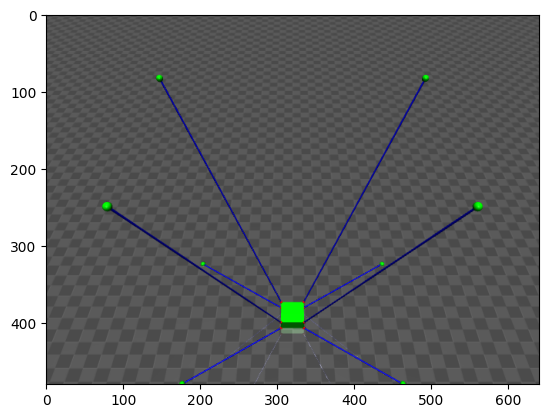

In [22]:
renderer=mj.Renderer(cdpr_model, height=480, width=640)
mj.mj_step(cdpr_model, cdpr_data)
renderer.update_scene(cdpr_data, camera="main_camera")
render=renderer.render()
plt.imshow(render)
plt.show()

In [23]:
def circle_path(theta, radius, height):
    return np.array([radius*np.cos(theta), radius*np.sin(theta), height])

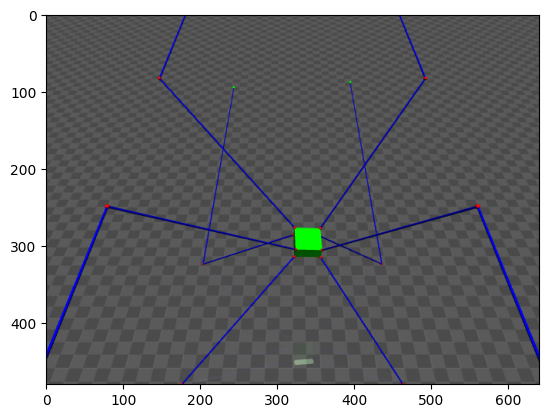

In [29]:
import time
from IPython import display
%matplotlib inline

#Controls 0 to 7 inclusive control cable tendons 0 to 7 inclusive.
#Every mujoco simulation step moves forward by 0.002 seconds by default.

desired_position=[1,1,8]
desired_orientation=[5,5,2]
timestamps=[]
cdpr.first_pid_run=True
cdpr.reset_cable_tensions_list()

real_time=True
wal_start_time= time.time()
sim_start_time = cdpr_data.time
for _ in range(int(10/cdpr_model.opt.timestep)+1):
    cdpr_data.ctrl= cdpr.ol_joint_position_control(wrench=cdpr.static_wrench,target_xyz=desired_position,target_orientation=desired_orientation)
    timestamps.append(cdpr_data.time)
    mj.mj_step(cdpr_model, cdpr_data)
    if real_time:
        if (time.time() - wal_start_time)>=(cdpr_data.time-sim_start_time):
            continue
    else:
        if _%100!=0:
            continue
    renderer.update_scene(cdpr_data, camera="main_camera")
    render=renderer.render()
    plt.imshow(render)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [30]:
actual_ee_rot_mat=np.stack([cdpr_data.sensor("end_effector_xv").data, cdpr_data.sensor("end_effector_yv").data, cdpr_data.sensor("end_effector_zv").data])
actual_ee_axis_angles=R.from_matrix(actual_ee_rot_mat).as_rotvec(degrees=True)
actual_ee_position=cdpr_data.sensor("end_effector_position").data
actual_ee_position, actual_ee_axis_angles

(array([1.00176215, 0.99910629, 7.99350282]),
 array([-4.99370061, -5.00138012, -1.9979129 ]))

In [31]:
sensed_cable_lengths=cdpr.sense_cable_lengths(cdpr_data)
cdpr.forward_kinematics(sensed_cable_lengths)

array([1.00176723, 0.99909711, 7.99350407, 4.99355641, 5.00179155,
       2.0002089 ])

In [27]:
import time
from IPython import display
import mediapy as media
%matplotlib inline

framerate=60
frames=[]
video_length=10
cdpr_model.opt.timestep=0.002
total_steps=int(video_length/cdpr_model.opt.timestep)

#This code here is for rendering a video, very similar to above code block, though.
cdpr.first_pid_run=True
desired_position=[0,0,cdpr.machine_frame_height/2]
desired_orientation=[0,0,0]
mj.mj_resetData(cdpr_model, cdpr_data)
ee_position_data=[]
cable_force_data=[[] for _ in range(cdpr.num_cables)] #List of lists, each sublist corresponds to a cable.
timestamps=[]
cdpr.reset_cable_tensions_list()

wal_start_time= time.time()
sim_start_time = cdpr_data.time
for _ in range(total_steps+1):
    cdpr_data.ctrl=cdpr.cl_joint_position_control(target_xyz=circle_path(_/total_steps*2*np.pi*5,cdpr.machine_frame_width/3,_/total_steps*cdpr.machine_frame_height),target_orientation=desired_orientation,cdpr_data=cdpr_data)
    ee_position_data.append(cdpr_data.sensor("end_effector_position").data.copy()) #Otherwise the data list will reference the same reading.
    timestamps.append(cdpr_data.time) #Is a scalar value, so no need to specify a copy.
    for i in range(cdpr.num_cables):
        cable_force_data[i].append(cdpr_data.sensor(f"cable_tendon_force_{i}").data.copy())
    mj.mj_step(cdpr_model, cdpr_data)
    if len(frames) < cdpr_data.time * framerate:
        renderer.update_scene(cdpr_data)
        render=renderer.render()
        frames.append(render)
media.show_video(frames, fps=framerate)

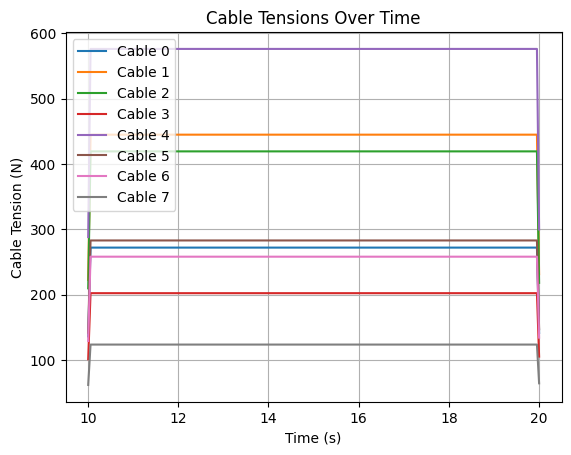

In [32]:
#Can only be run successfully if ol_joint_position_control is used.
for i in range(cdpr.num_cables):
    N=50
    mean_kernel = np.ones(N)/N
    filtered_sig = np.convolve(cdpr.calculated_cable_tensions[i], mean_kernel, mode='same')
    plt.plot(timestamps, filtered_sig, label=f"Cable {i}")
plt.xlabel("Time (s)")
plt.ylabel("Cable Tension (N)")
plt.title("Cable Tensions Over Time")
plt.legend()
plt.grid()
plt.show()

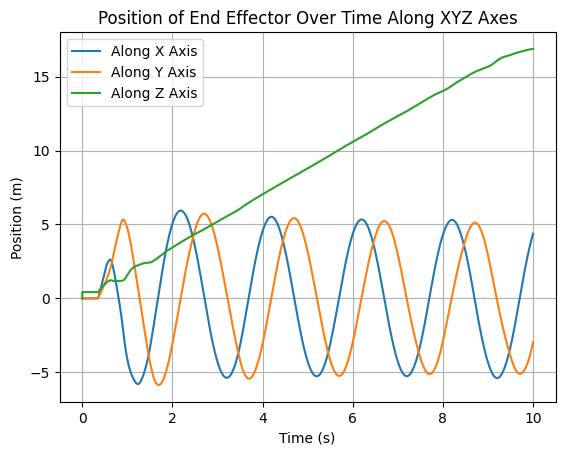

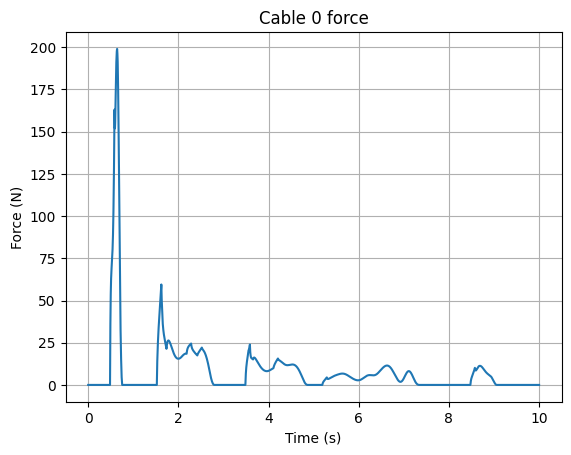

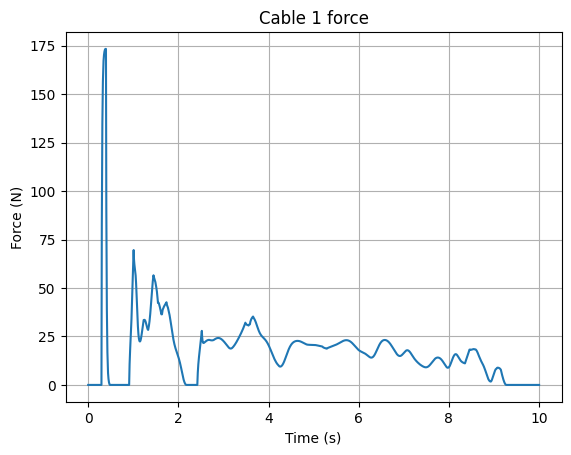

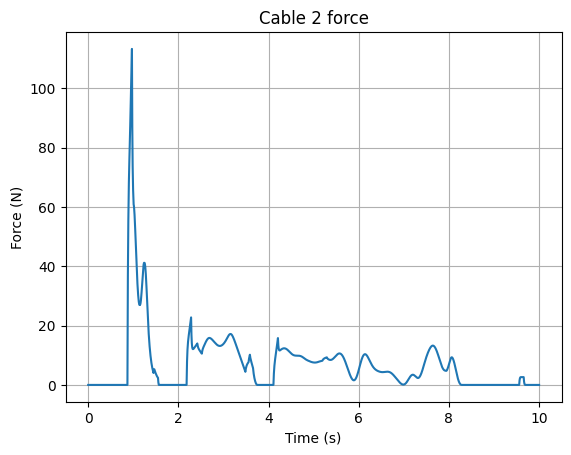

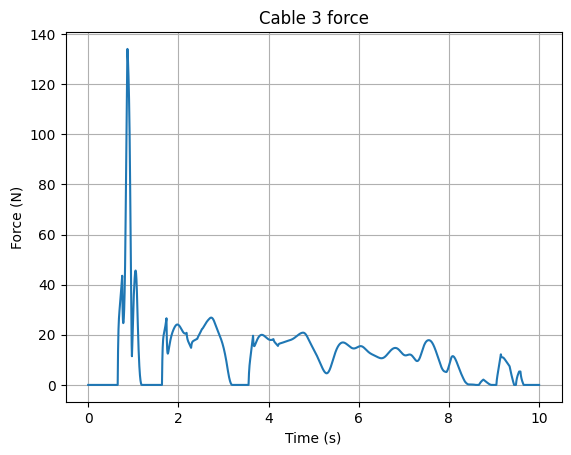

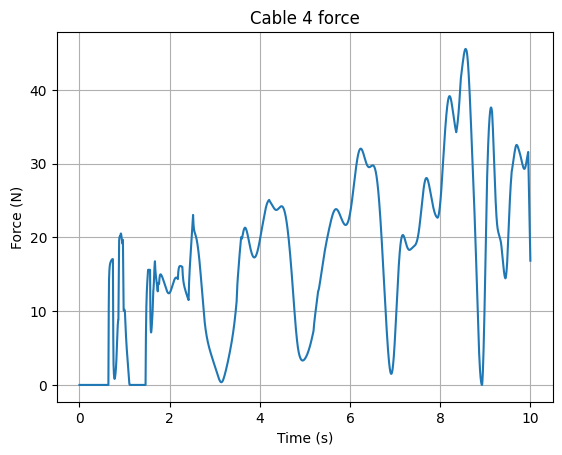

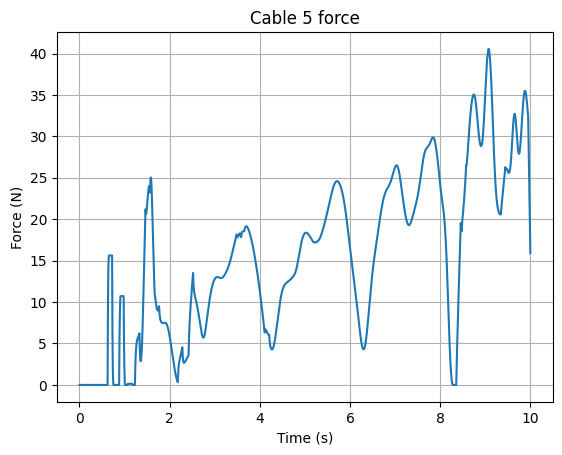

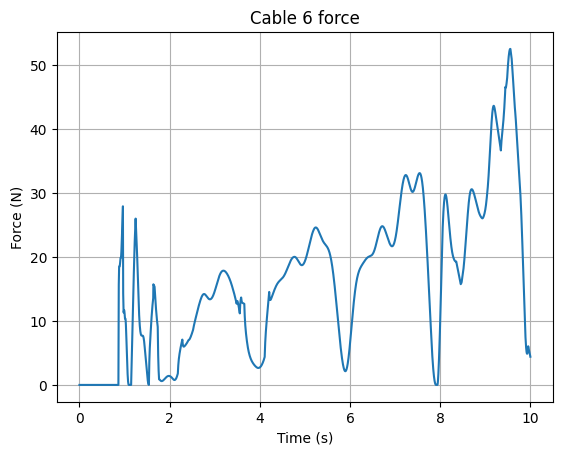

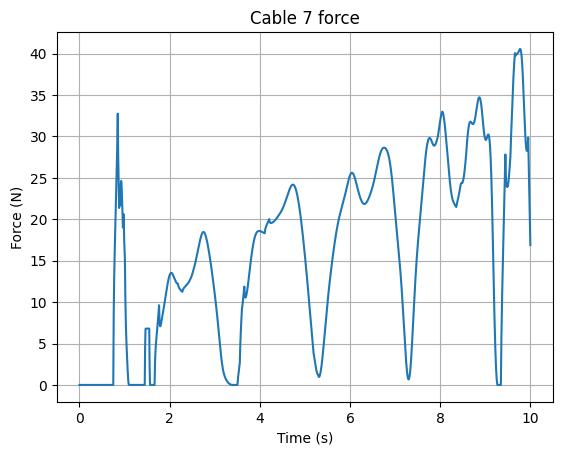

In [ ]:
plt.plot(timestamps, ee_position_data)
plt.title("Position of End Effector Over Time Along XYZ Axes")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend(["Along X Axis", "Along Y Axis", "Along Z Axis"])
plt.grid()
plt.show()
for _ in range(cdpr.num_cables):
    N=50
    mean_kernel = np.ones(N)/N
    filtered_sig = np.convolve(np.concatenate(cable_force_data[_]), mean_kernel, mode='same')
    plt.plot(timestamps, filtered_sig)
    plt.title(f"Cable {_} force")
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.grid()
    plt.show()